# Simple RNN 를 이용한 SMS Spam 분류
캐글 데이터 

### 텍스트 전처리

In [1]:
import numpy as np 
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
from google.colab import files
up = files.upload()

Saving spam.csv to spam.csv


In [3]:
import pandas as pd 
df = pd.read_csv('spam.csv', encoding='latin1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [4]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

1. 컬럼 지우기 => 셀렉션의 문제 드랍이냐 셀렉이냐.
2. Null data 제거 = > 없음.

In [5]:
df = df[['v1','v2']]        # df.drop(columns=['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'], inplace=True)
df.head(3)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [6]:
#  Null  데이터 제거 없음 
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [7]:
# 중복데이터 확인
df.shape, df.v2.nunique()

((5572, 2), 5169)

In [8]:
# 중복데이터 제거 
df.drop_duplicates(subset=['v2'], inplace=True)
df.shape

(5169, 2)

In [9]:
# ['ham', 'spam'] ---> [0, 1]
df.v1 = df.v1.replace(['ham', 'spam'], [0,1])
df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [10]:
# Ham / Spam 갯수
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

### 텍스트 전처리 완료 후 저장. 

In [11]:
df.to_csv('spam_전처리완료.csv', index=False)

In [12]:
# x, y data
x = df.v2.values
y = df.v1.values
x.shape, y.shape

((5169,), (5169,))

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
# 구둣점 게거 , 소문자 변환
import re

def preprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    s = re.sub('[^a-z0-9 ]', '', s.lower())    # s.lower() 체크
    return s

In [15]:
X_data = [preprocessing(sent) for sent in x]
X_data[2]
# 구둣점 없어지고 숫자하고 영어 문자만 남았어. 

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

In [16]:
# X data에 대해서 단어집합을 만들고 그 크기를 확인 
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
vocab_size

9479

In [17]:
sequences = t.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3839, 84, 3840, 424, 3841]


In [18]:
max_len = max(len(seq) for seq in sequences)
max_len

171

In [18]:
# 패딩 옵션 변화하는지 확인해 보기.  y 가 0.1  어제와 다르게 타입스텝 때문에 y가까이의 모양을 예쁘게 하기위해 패딩을 pre로 해줄 필요가 없어. 
# 전체 데이터셋의 길이를 max_len 에 맞추되
# 0 padding은 뒤쪽으로 해준다.  

# 패딩 pre 버전
# 패딩 post 버전 나누어 해보자

### 패딩 post

In [19]:
data = pad_sequences(sequences, maxlen=max_len, padding='post')
data.shape

(5169, 171)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, y, stratify=y, test_size=0.2, random_state=seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

### 모델 post 정의/설정/학습 

In [44]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [22]:
model_post = Sequential([ 
    Embedding(vocab_size, 32, input_length=max_len),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model_post.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 32)           303328    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 305,441
Trainable params: 305,441
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_post.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
)

In [24]:
hist = model_post.fit(X_train, y_train, epochs=10,
                    batch_size=60, validation_split=0.2, verbose=2)

Epoch 1/10
56/56 - 16s - loss: 0.4400 - accuracy: 0.8431 - val_loss: 0.3416 - val_accuracy: 0.8948 - 16s/epoch - 278ms/step
Epoch 2/10
56/56 - 10s - loss: 0.3896 - accuracy: 0.8685 - val_loss: 0.3427 - val_accuracy: 0.8948 - 10s/epoch - 170ms/step
Epoch 3/10
56/56 - 9s - loss: 0.3891 - accuracy: 0.8685 - val_loss: 0.3364 - val_accuracy: 0.8948 - 9s/epoch - 163ms/step
Epoch 4/10
56/56 - 9s - loss: 0.3904 - accuracy: 0.8685 - val_loss: 0.3422 - val_accuracy: 0.8948 - 9s/epoch - 163ms/step
Epoch 5/10
56/56 - 9s - loss: 0.3903 - accuracy: 0.8685 - val_loss: 0.3391 - val_accuracy: 0.8948 - 9s/epoch - 166ms/step
Epoch 6/10
56/56 - 9s - loss: 0.3897 - accuracy: 0.8685 - val_loss: 0.3399 - val_accuracy: 0.8948 - 9s/epoch - 168ms/step
Epoch 7/10
56/56 - 10s - loss: 0.3897 - accuracy: 0.8685 - val_loss: 0.3438 - val_accuracy: 0.8948 - 10s/epoch - 187ms/step
Epoch 8/10
56/56 - 9s - loss: 0.3905 - accuracy: 0.8685 - val_loss: 0.3418 - val_accuracy: 0.8948 - 9s/epoch - 163ms/step
Epoch 9/10
56/56 -

In [25]:
model_post.evaluate(X_test, y_test)

33/33 [==============================] - 1s 25ms/step - loss: 0.3835 - accuracy: 0.8733


[0.3834589421749115, 0.8733075261116028]

In [ ]:
import matplotlib.pyplot as plt
y_loss = hist.history['loss']
y_vloss = hist.history['val_loss']
x_len = range(1, len(y_loss)+1)
plt.plot(x_len, y_loss, label='loss')
plt.plot(x_len, y_vloss, label='val_loss')
plt.legend()
plt.show()

In [ ]:
# 왜 로스가 그래도 일정한 것이냐?? 
# 왜 이렇게 시끄러운 것이냐. 

# 패딩 프리

In [22]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [19]:
data = pad_sequences(sequences, maxlen=max_len, padding='pre')
data.shape

(5169, 171)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, y, stratify=y, test_size=0.2, random_state=seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

In [23]:
model_pre = Sequential([ 
    Embedding(vocab_size, 32, input_length=max_len),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model_pre.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 32)           303328    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 305,441
Trainable params: 305,441
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_pre.compile('adam', 'binary_crossentropy', ['accuracy'])

In [25]:
model_path = 'best-spam.h5'
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
early_stop = EarlyStopping(patience=10)

In [26]:
hist_pre = model_pre.fit(X_train, y_train, epochs=100, batch_size=64,
                        validation_split=0.2, callbacks=[checkpoint, early_stop], verbose=2)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.24656, saving model to best-spam.h5
52/52 - 8s - loss: 0.4025 - accuracy: 0.8558 - val_loss: 0.2466 - val_accuracy: 0.8984 - 8s/epoch - 149ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 0.24656 to 0.12390, saving model to best-spam.h5
52/52 - 6s - loss: 0.1691 - accuracy: 0.9516 - val_loss: 0.1239 - val_accuracy: 0.9686 - 6s/epoch - 117ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 0.12390 to 0.09233, saving model to best-spam.h5
52/52 - 5s - loss: 0.0722 - accuracy: 0.9846 - val_loss: 0.0923 - val_accuracy: 0.9758 - 5s/epoch - 105ms/step
Epoch 4/100

Epoch 00004: val_loss improved from 0.09233 to 0.08126, saving model to best-spam.h5
52/52 - 5s - loss: 0.0394 - accuracy: 0.9940 - val_loss: 0.0813 - val_accuracy: 0.9758 - 5s/epoch - 105ms/step
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.08126
52/52 - 5s - loss: 0.0787 - accuracy: 0.9713 - val_loss: 0.3485 - val_accuracy: 0.9021 - 5s/epoch - 104m

In [27]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)
# 33/33 [==============================] - 1s 19ms/step - loss: 0.3814 - accuracy: 0.8733
# [0.3813613951206207, 0.8733075261116028]

33/33 [==============================] - 1s 18ms/step - loss: 0.0832 - accuracy: 0.9749


[0.08315490186214447, 0.9748549461364746]

In [28]:
y_acc = hist_pre.history['accuracy']
y_vloss = hist_pre.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

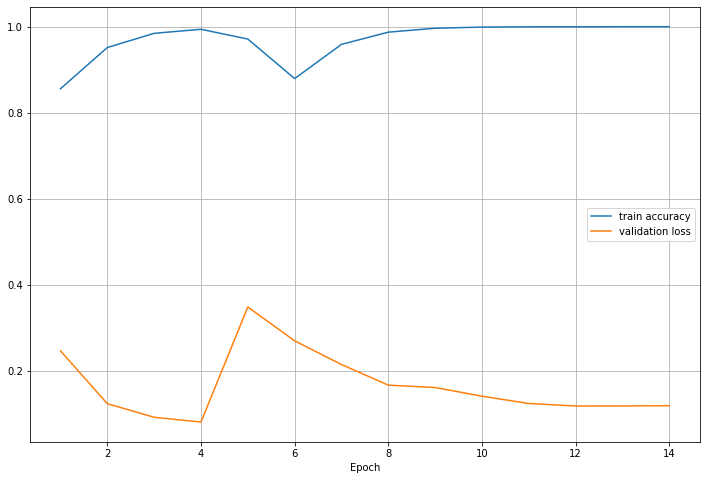

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.xlabel('Epoch')
plt.grid(), plt.legend()
plt.show()

In [45]:
## 수업과 tanh 준 버전 달랐어 tanh는 심플리 RNN 기본 활성화 함수. 
# 시각화 코드 변경. 